In [44]:
from multi_scale_edge_detection.MultiScaleContourDetector import multi_scale_contour_detection_with_inhibition, multi_scale_contour_detection_without_inhibition
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [45]:


def preprocess_image(image):
    # Use Canny edge detector to find edges
    edges = multi_scale_contour_detection_with_inhibition(image, N=4, sigma=1, alpha=0.001)
    
    return edges



def assign_direction_vectors(edges, threshold=0.5):
    # Compute the gradient in the x and y direction
    grad_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude and direction
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y)
    
    # Initialize arrays to store direction vector components for each pixel
    direction_vectors_x = np.zeros_like(edges, dtype=np.float64)
    direction_vectors_y = np.zeros_like(edges, dtype=np.float64)

    # Calculate direction vector for each pixel
    for i in range(edges.shape[0]):  # Iterate over rows
        for j in range(edges.shape[1]):  # Iterate over columns
            if magnitude[i, j] > threshold:
                angle_rad = angle[i, j]
                x_component = magnitude[i, j] * np.cos(angle_rad)
                y_component = magnitude[i, j] * np.sin(angle_rad)
                direction_vectors_x[i, j] = x_component
                direction_vectors_y[i, j] = y_component
    
    # Combine the direction vectors into a single array
    image_directions = np.stack((direction_vectors_x, direction_vectors_y), axis=2)



    return image_directions




# Example usage
image = cv2.imread('database/images/rino.pgm', cv2.IMREAD_UNCHANGED)  # Replace with your image path
edges = preprocess_image(image)
model = assign_direction_vectors(edges, threshold=0.5)




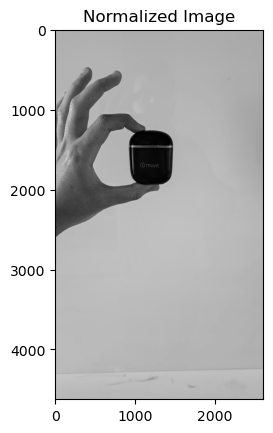

In [46]:
im1 = cv2.imread('muvit1 (1).jpg' , cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('muvit1 (2).jpg' , cv2.IMREAD_GRAYSCALE)

if im1 is None:
    print("Error: Unable to read the image.")
else:
    # Convert to float
    im1 = im1.astype(float)
    im2 = im2.astype(float)

    # Normalize the image values to be between 0 and 1
    image_normalized = (im1 - im1.min()) / (im1.max() - im1.min())
    im2 = (im2 - im2.min()) / (im2.max() - im2.min())

    #Display the normalized image
    plt.imshow(image_normalized, cmap='gray')
    plt.title('Normalized Image')
    plt.show()



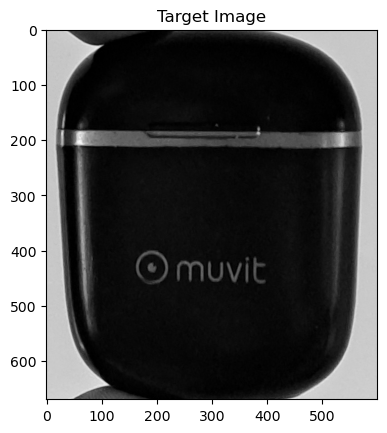

In [47]:
targ = im1[1270:1940, 900:1500]
plt.imshow(targ, cmap='gray')
plt.title('Target Image')
plt.show()

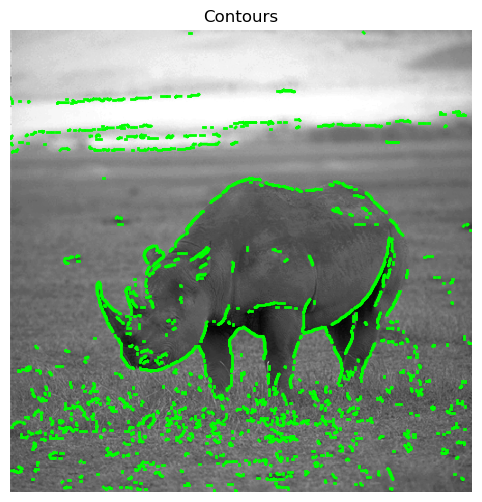

In [48]:
# Find contours
cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # Handling OpenCV version differences

# Plot the contours
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
for c in cnts:
    plt.plot(c[:, 0, 0], c[:, 0, 1], color='lime', linewidth=2)
plt.title('Contours')
plt.axis('off')
plt.show()

In [49]:
# Print the structure of cnts
print("Structure of cnts:")
print("Type:", type(cnts))
print("Length:", len(cnts))
print("Type of an individual contour:", type(cnts[0]))
print("Shape of an individual contour:", cnts[0].shape)

# Print the structure of an individual contour (c)
c = cnts[0]  # Selecting the first contour for demonstration
print("\nStructure of an individual contour (c):")
print("Type:", type(c))
print("Shape:", c.shape)

Structure of cnts:
Type: <class 'tuple'>
Length: 1425
Type of an individual contour: <class 'numpy.ndarray'>
Shape of an individual contour: (3, 1, 2)

Structure of an individual contour (c):
Type: <class 'numpy.ndarray'>
Shape: (3, 1, 2)


In [50]:

def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.
    
    Parameters:
    - vector_a: First vector (numpy array).
    - vector_b: Second vector (numpy array).
    
    Returns:
    - similarity: Cosine similarity between vector_a and vector_b.
    """
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    if norm_a*norm_b == 0:
        return 0
    similarity = dot_product / (norm_a * norm_b)
    return similarity


def model_image_similarity(model_directions, image_directions):
    """
    Compute the similarity measure between a model and an image based on points and associated direction vectors.
    
    Parameters:
    - model_directions: List of direction vectors (numpy arrays) for the model points.
    - image_directions: List of direction vectors (numpy arrays) for the image points.
    
    Returns:
    - average_similarity: The average cosine similarity between corresponding direction vectors of model and image points.
    """
    similarities = []
    for i in range(min(model_directions.shape[0], image_directions.shape[0])):
        for j in range(min(model_directions.shape[1], image_directions.shape[1])):
            similarity = cosine_similarity(model_directions[i][j], image_directions[i][j])
            similarities.append(similarity)
    
    if len(similarities) == 0:
        return 0.0  # Handle case where there are no similarities
    
    average_similarity = np.mean(similarities)
    return average_similarity


## version 2 of the cosin similarity

In [51]:
import numpy as np

def adjust_shapes(vectors_a, vectors_b):
    """
    Adjust the shapes of two arrays to make them compatible for element-wise operations.
    Handles both 2D and 3D arrays by adjusting the number of rows for 2D arrays
    and the number of columns for 3D arrays.
    """
    if vectors_a.ndim == 2 and vectors_b.ndim == 2:
        # For 2D arrays, adjust the number of rows (vectors)
        min_rows = min(vectors_a.shape[0], vectors_b.shape[0])
        vectors_a_adjusted = vectors_a[:min_rows, :]
        vectors_b_adjusted = vectors_b[:min_rows, :]
    elif vectors_a.ndim == 3 and vectors_b.ndim == 3:
        # For 3D arrays, adjust the number of columns (vectors) in each row
        min_columns = min(vectors_a.shape[1], vectors_b.shape[1])
        vectors_a_adjusted = vectors_a[:, :min_columns, :]
        vectors_b_adjusted = vectors_b[:, :min_columns, :]
    else:
        raise ValueError("Incompatible array dimensions: both arrays must be either 2D or 3D.")
    
    return vectors_a_adjusted, vectors_b_adjusted

def optimized_cosine_similarity(vectors_a, vectors_b):
    """
    Calculate the cosine similarity between two sets of vectors in a vectorized manner.
    This function handles both 2D and 3D arrays by adjusting their shapes to be compatible for element-wise operations.
    """
    # Adjust the shapes of the vectors to ensure compatibility
    vectors_a, vectors_b = adjust_shapes(vectors_a, vectors_b)

    # Calculate dot products
    dot_products = np.sum(vectors_a * vectors_b, axis=-1)

    # Calculate norms
    norms_a = np.linalg.norm(vectors_a, axis=-1)
    norms_b = np.linalg.norm(vectors_b, axis=-1)

    # Avoid division by zero by adding a small constant
    epsilon = 1e-10
    similarities = dot_products / (norms_a * norms_b + epsilon)

    return similarities



def optimized_model_image_similarity(model_directions, image_directions):
    """
    Compute the similarity measure between a model and an image in a vectorized manner,
    with shape adjustment for compatibility.
    
    Parameters:
    - model_directions: Array of direction vectors for the model points.
    - image_directions: Array of direction vectors for the image points.
    
    Returns:
    - average_similarity: The average cosine similarity between corresponding direction vectors.
    """
    # Adjust shapes for compatibility
    model_directions, image_directions = adjust_shapes(model_directions, image_directions)
    
    # Ensure the arrays have compatible shapes for vectorized operations
    similarities = optimized_cosine_similarity(model_directions.reshape(-1, 2), image_directions.reshape(-1, 2))
    
    # Compute the average similarity
    average_similarity = np.mean(similarities)
    
    return average_similarity

# Commented out to prevent execution in the PCI
# model_dirs = np.random.rand(190, 248, 2)  # Example model directions with adjusted shape
# image_dirs = np.random.rand(190, 250, 2)  # Example image directions with adjusted shape
# print(optimized_model_image_similarity(model_dirs, image_dirs))


In [52]:
def template_matching(template, target):
    # Find template dimensions
    th, tw = template.shape[:2]

    # Compute the barycenter of the target image
    ty, tx = target.shape[:2]
    barycenter_x = tx // 2
    barycenter_y = ty // 2

    # Compute the size of the ROI
    roi_size_x = tw * 4
    roi_size_y = th * 4

    # Define the ROI boundaries
    roi_x = max(0, barycenter_x - roi_size_x // 2)
    roi_y = max(0, barycenter_y - roi_size_y // 2)
    roi_width = min(tx - roi_x, roi_size_x)
    roi_height = min(ty - roi_y, roi_size_y)
    edge_template = preprocess_image(template)
    model_temp = assign_direction_vectors(edge_template)
    target_edge = preprocess_image(target)
    target_model = assign_direction_vectors(target_edge)

    # Slide template over the target image within the ROI and calculate similarity scores
    best_similarity = 0.0
    best_location = None
    step_size = 5 # Define step size for moving the template

    

    for y in range(roi_y, roi_y + roi_height - th, step_size):
        for x in range(roi_x, roi_x + roi_width - tw, step_size):
            model_roi = target_model[y:y+th, x:x+tw]
            similarity =optimized_model_image_similarity(model_temp, model_roi) #model_image_similarity2(model_temp, model_roi)

            
            if similarity > best_similarity:
                best_similarity = similarity
                best_location = (x, y)
                
                plt.imshow(target, cmap="gray")   # Convert BGR to RGB for matplotlib
                plt.gca().add_patch(plt.Rectangle((best_location[0], best_location[1]), tw, th, edgecolor='g', linewidth=2, fill=False))
                plt.show()
                    
                    
                print(f"Best location: {best_location}, Best similarity: {best_similarity}")
                print(f"model roi dimension: {model_roi.shape[0], model_roi.shape[1]}, model edge dimension: {model_temp.shape[0], model_temp.shape[1]}")
    
    
    return best_location



In [60]:
import cv2

# Path to the video file
video_path = 'phone_100fps (1).avi'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Initialize an empty list to store frames
frames = []

# Read the video frame by frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Append the frame to the frames list
    frames.append(frame)

# Release the video capture object
cap.release()

# Convert the list of frames to a numpy array
frames_array = np.array(frames)

# Print the shape of the frames array
print("Shape of frames array:", frames_array.shape)


Shape of frames array: (2300, 480, 640, 3)


In [61]:
normalized_frames = []

# Iterate over each frame array
for frame in frames_array:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Normalize the pixel values to range [0, 1]
    normalized_frame = gray_frame / 255.0
    
    # Append the normalized grayscale frame to the list
    normalized_frames.append(normalized_frame)

print("Normalization and storing completed.")

Normalization and storing completed.


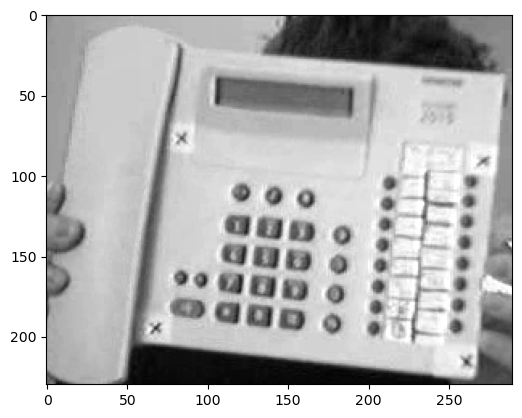

In [64]:
temp1 = normalized_frames[100][110:340,150:440]

plt.imshow(temp1, cmap="gray")


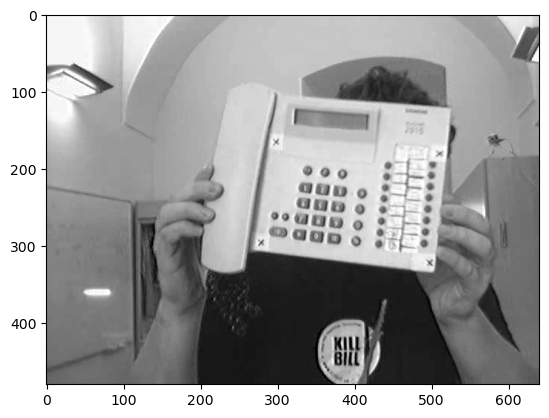

In [67]:
plt.imshow(normalized_frames[88], cmap="gray")    

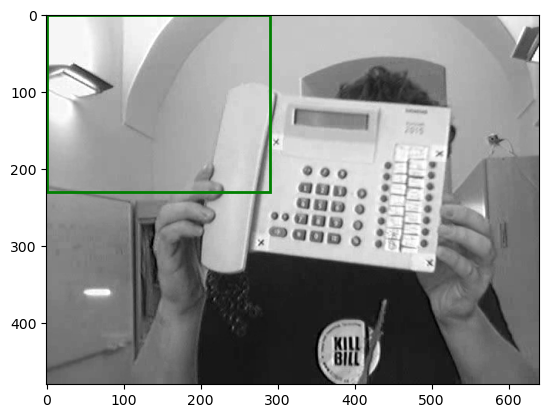

Best location: (0, 0), Best similarity: 0.00028346332995220956
model roi dimension: (230, 290), model edge dimension: (232, 288)


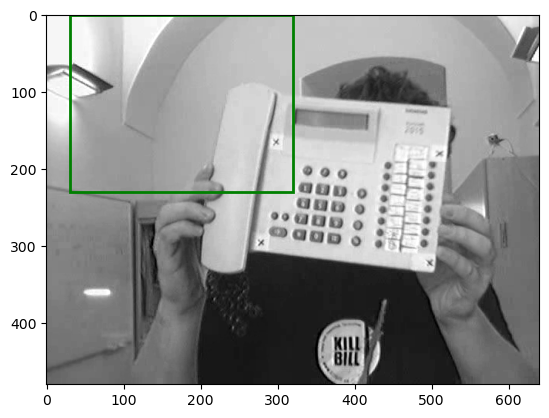

Best location: (30, 0), Best similarity: 0.0003227805619333466
model roi dimension: (230, 290), model edge dimension: (232, 288)


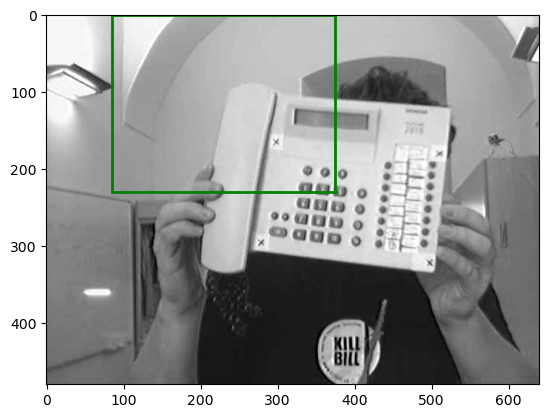

Best location: (85, 0), Best similarity: 0.0005612004105834063
model roi dimension: (230, 290), model edge dimension: (232, 288)


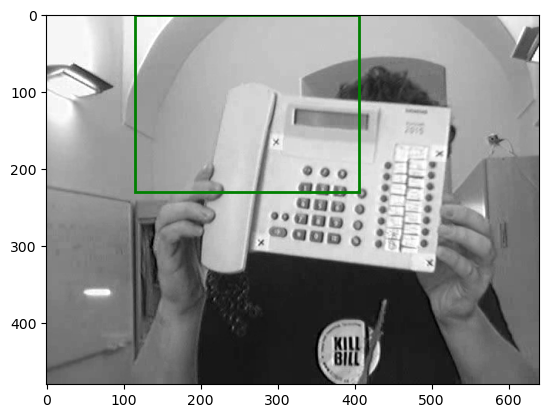

Best location: (115, 0), Best similarity: 0.0007621822851524543
model roi dimension: (230, 290), model edge dimension: (232, 288)


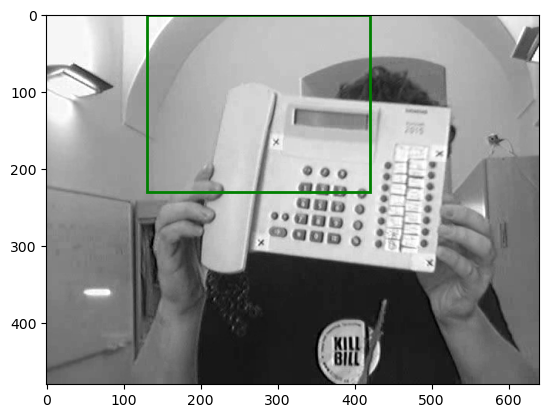

Best location: (130, 0), Best similarity: 0.0009721753031856033
model roi dimension: (230, 290), model edge dimension: (232, 288)


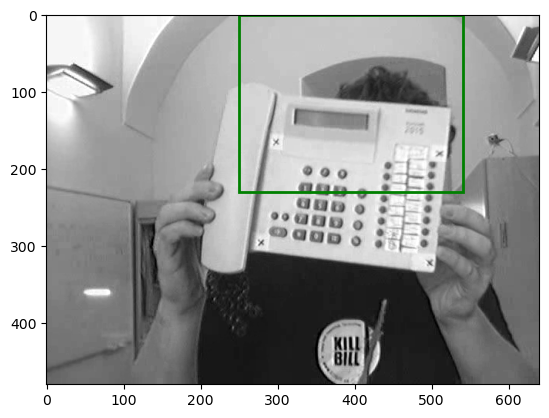

Best location: (250, 0), Best similarity: 0.000991103812435198
model roi dimension: (230, 290), model edge dimension: (232, 288)


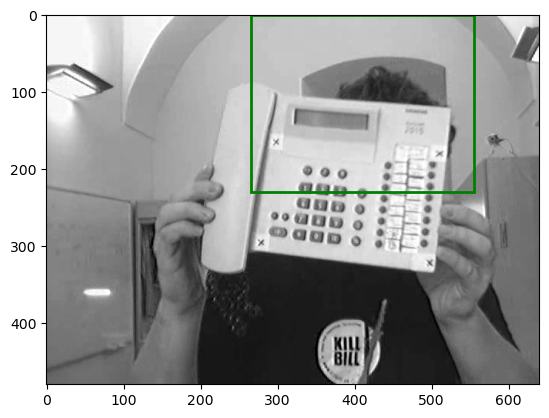

Best location: (265, 0), Best similarity: 0.0011836930269604144
model roi dimension: (230, 290), model edge dimension: (232, 288)


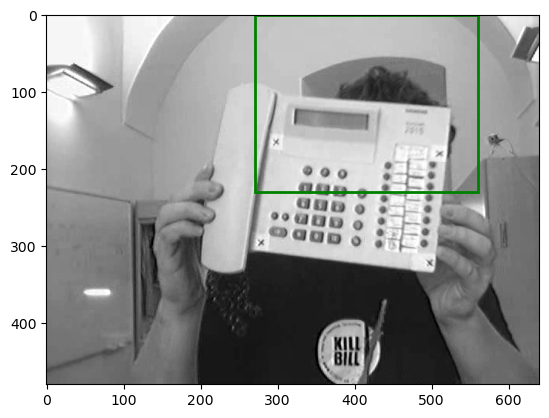

Best location: (270, 0), Best similarity: 0.0014407286594558368
model roi dimension: (230, 290), model edge dimension: (232, 288)


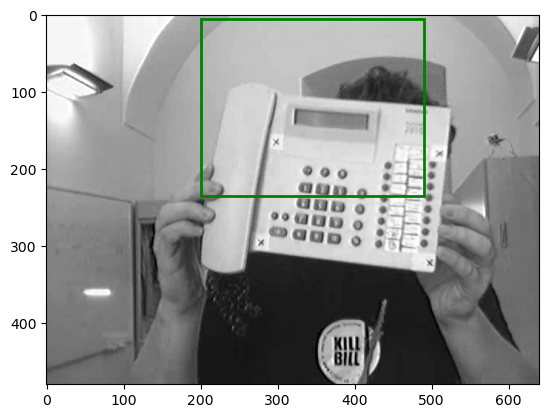

Best location: (200, 5), Best similarity: 0.001482410586688462
model roi dimension: (230, 290), model edge dimension: (232, 288)


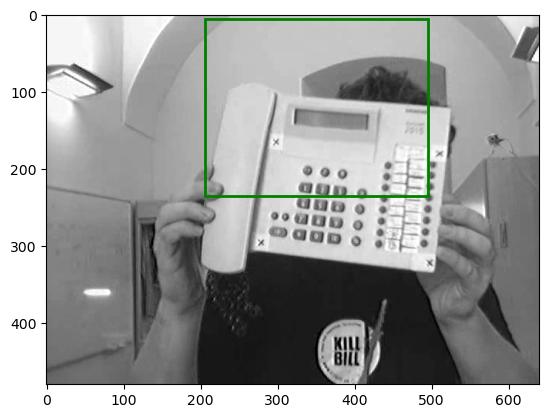

Best location: (205, 5), Best similarity: 0.0016392342655020475
model roi dimension: (230, 290), model edge dimension: (232, 288)


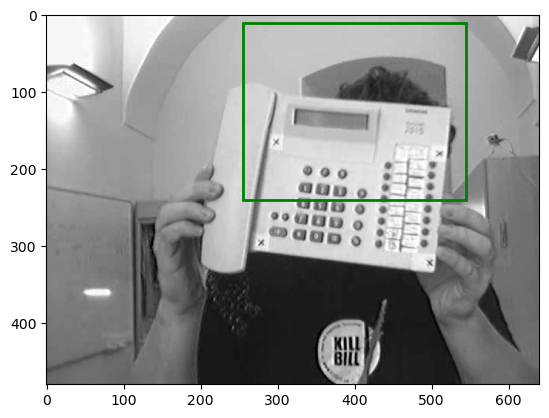

Best location: (255, 10), Best similarity: 0.001919950436444311
model roi dimension: (230, 290), model edge dimension: (232, 288)


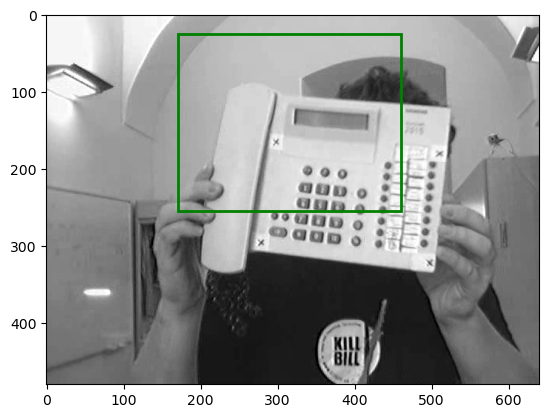

Best location: (170, 25), Best similarity: 0.0021334180022512294
model roi dimension: (230, 290), model edge dimension: (232, 288)


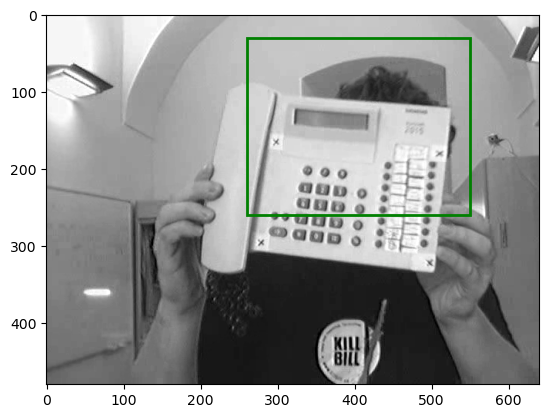

Best location: (260, 30), Best similarity: 0.0022046984983224637
model roi dimension: (230, 290), model edge dimension: (232, 288)


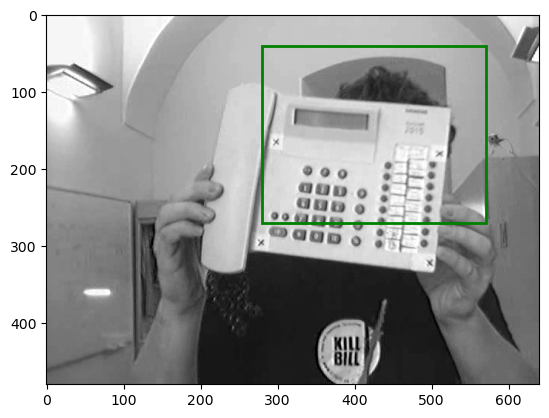

Best location: (280, 40), Best similarity: 0.0027006535134023566
model roi dimension: (230, 290), model edge dimension: (232, 288)


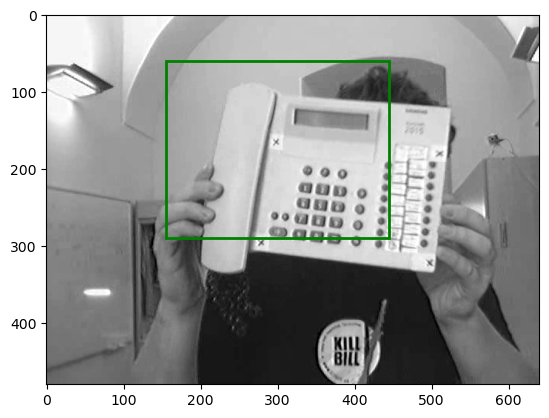

Best location: (155, 60), Best similarity: 0.002831860573693825
model roi dimension: (230, 290), model edge dimension: (232, 288)


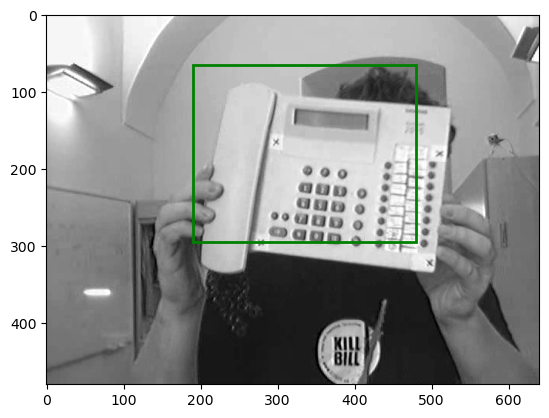

Best location: (190, 65), Best similarity: 0.0032489502685960495
model roi dimension: (230, 290), model edge dimension: (232, 288)


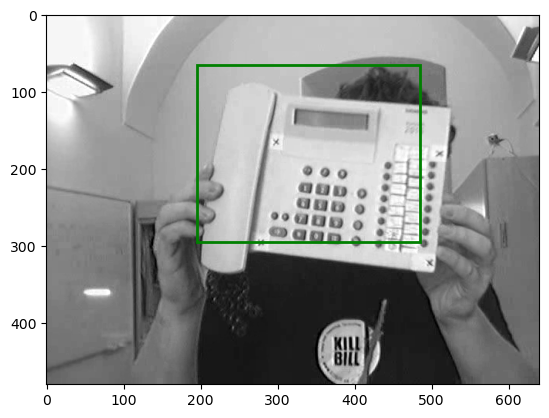

Best location: (195, 65), Best similarity: 0.0045010691096055615
model roi dimension: (230, 290), model edge dimension: (232, 288)


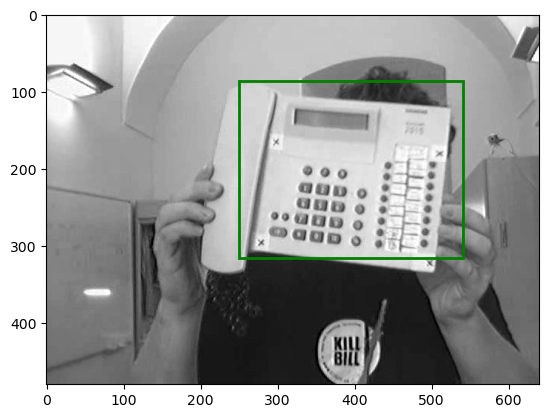

Best location: (250, 85), Best similarity: 0.004580082058454187
model roi dimension: (230, 290), model edge dimension: (232, 288)


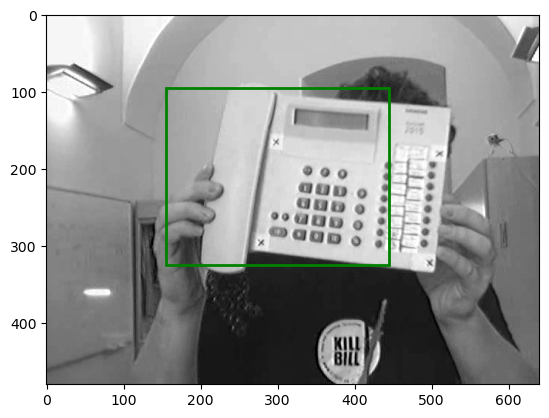

Best location: (155, 95), Best similarity: 0.006282821039913831
model roi dimension: (230, 290), model edge dimension: (232, 288)


In [68]:
if __name__ == "__main__":
    # Load images
    template_img = temp1
    target_img = normalized_frames[88]

    # Find the best location for template matching
    best_loc = template_matching(template_img, target_img )

   

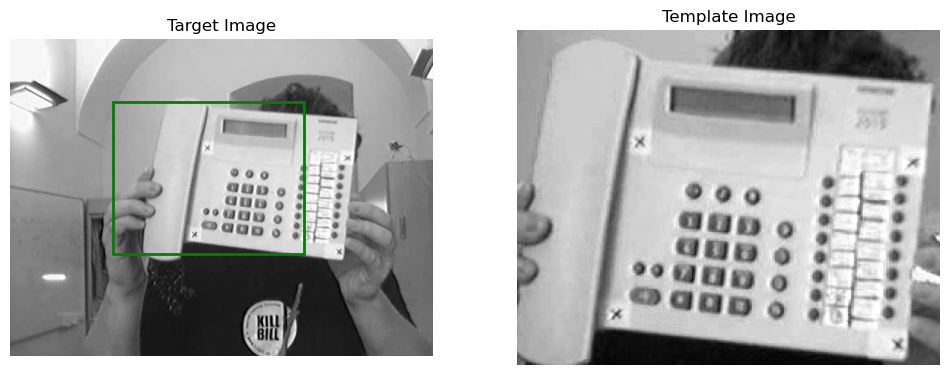

In [69]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the target image with rectangle highlighting the best location
ax1.imshow(target_img, cmap="gray")
ax1.set_title("Target Image")
ax1.add_patch(plt.Rectangle((best_loc[0], best_loc[1]), template_img.shape[1], template_img.shape[0], edgecolor='g', linewidth=2, fill=False))

# Plot the template image
ax2.imshow(template_img, cmap="gray")
ax2.set_title("Template Image")

# Remove axis for both subplots
ax1.axis('off')
ax2.axis('off')

# Save the figure as PNG without the surrounding white space
plt.savefig('result.png', bbox_inches='tight', pad_inches=0)

plt.show()

